<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/60_Ultra_Lite_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%A2%D0%B5%D0%BA%D1%81%D1%82%D0%B0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Перепишите ноутбук своими руками. Часть ноутбука можно копировать, но для запоминания важно переписать самому.

Функции работы с текстом.

Чтение данных.

Преобразование текста в индексы: формирование xTrain.

Формирование yTrain.

Разделение выборки на окна.

Одну из функций для создания моделей.

Функция подсчета ошибки.

Создание xTrain и yTrain при помощи метода Word2wec GENSIM.

Обучите сеть и проверьте, что она достигает приблизительно похожих результатов, как и на занятии.

# Сегментация договоров при помощи Linear Conv1D, PSPNet, UNET.

## Импорт библиотек

In [ ]:
!pip install -q pymorphy2 # установка лемматизатора 

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 10.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import time
import re  # для работы со строками
import tensorflow
import matplotlib.pyplot as plt
import os
import pymorphy2

import nltk # Natural language toolkit - инструментарий естественного языка
from nltk.stem import WordNetLemmatizer # для работы с леммами

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model  # импортируем Model, метод, который загружает импортированную НС load_model
from tensorflow.keras.preprocessing.text import Tokenizer # метод, который позволяет работать с текстами и конвертировать их в последовательности (индексов)
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPool1D, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K # для вычисления dice_coef (ошибки)
from tensorflow.keras.optimizers import Adam, Adadelta # импортируем оптимизаторы
from tensorflow.keras import utils # для работы с категориальными данными
from google.colab import files # для работы с файлами

from gensim.models import word2vec 

nltk.download('wordnet') # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Функции для работы с текстами

Превращаем договоры ы листы слов

### Лист тегов и их значений

< s1 > - Условия
 
< s2 > - Запреты

< s3 > - Цена

< s4 > - Даты и сроки (условия)

< s5 > - Штрафы

< s6 > - Адреса и местополодения

In [ ]:
# Считываем текст из файла и удаляем все ненужные нам знаки, в т.ч. знаки препинания и пунктуации
def readText(fileName):
  f = open(fileName, 'r')          # открываем файл и считываем данные
  text = f.read()                  # помещаем наш текст в пеерменную
# Определяем какие знаки будут удалены
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']
  for dS in delSymbols:            # каждый знак нашего списка будет удален из списка
    text = text.replace(dS, ' ')   # удаляем знак посредством замены знака на пробел

  # Выискиваем дополнительные знаки в тексте посредством паттернов и определяем на что их заменить
  text = re.sub("[.]", " ", text)
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)
  
  # split метод разделит текст на последовательности слов при помощи пробелов
  # (а их может быть очень много после наших удалений знаков), которые будут являться разделителями
  # Используя метод join мы обратно соберем последовательности слов в текст
  text = ' '.join(text.split())

  text = text.lower() # приводим текст к нижнему регистру
  return text

# Конвертируем исходный текст в лист слов с начальной формой
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # инициализируем инструмент для работы с морфемами
  words = text.split(' ')           # разделяем текст по пробелам
  docs = [morph.parse(word)[0].normal_form for word in words] # превращаем каждое слово в элемент списка
  return docs                       # возвращаем полученный документ

### Чтение данных

In [ ]:
directory = '/content/drive/MyDrive/Базы/Договоры 432/' # путь к папке с договорами
os.listdir(directory)[250:255]                         # выводим на экран названия 5-ти договоров  

['dogovor-zaloga-s-peredachej-predmeta-zaloga-zalogoderzhatelyu.txt',
 'dogovor-zaloga-privatizirovannoy-kvartiri.txt',
 'dogovor-zaloga-imuschestvennih-prav.txt',
 'dogovor-zaloga-imuschestva.txt',
 'dogovor-zaloga-imuschestva-kvartiri.txt']

In [ ]:
print('Всего ', len(os.listdir(directory)), ' договора')

Всего  432  договора


In [ ]:
cur_time = time.time()                                  # засекаем время
agreements = []                                         # лист, что будет хранить все наши договоры
for filename in os.listdir(directory):                  # проходимся по каждому договору
  txt = readText(directory + filename)                  # считываем текст в договоре
  if txt != '':                                         # если договор не пустой
    agreements.append(readText(directory + filename))   #  превращаем файл в текст и добавляем в agreement
print('Загрузка файла заняла: ', round(time.time() - cur_time, 2), 'c.')


Загрузка файла заняла:  3.06 c.


In [ ]:
n = 3
print(os.listdir(directory)[n])  # выводим название n-ого договора
agreements[n]                    # текст n-ого договора

2 (2).txt


'договор благотворительного пожертвования целевое использование г г в лице действующего на основании именуемый в дальнейшем благотворитель с одной стороны и в лице действующего на основании именуемый в дальнейшем благополучатель с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 общие положения 1 1 <s3> благотворитель передает благополучателю денежные средства благотворительное пожертвование для реализации благотворительной программы </s3> 1 2 цели программы 1 3 программа и бюджет прилагаются к договору и являются неотъемлемой частью настоящего договора 1 4 <s4> настоящий договор начинает действовать с года датой окончания договора является года настоящий договор вступает в силу с момента заключения и заканчивается после выполнения принятых сторонами на себя обязательств в соответствии с условиями договора </s4> 2 порядок предоставления и расходования пожертвования 2 1 <s3> общая сумма благотворительного пожертвования сост

In [ ]:
docs_full = []         # лист булет содержать все договоры как списки документов
cur_time = time.time() # запоминаем текущее время
for i in range(len(agreements)): # проходимся по каждому договору
  docs_full.append(text2Words(agreements[i])) # превращаем договор в лист слов и добавляем его в doc_full
print('Превращение заняло: ', round(time.time() - cur_time, 2), 'c.')

Превращение заняло:  153.56 c.


In [ ]:
print(len(docs_full)) # выводим число записей в наборе данных

422


In [ ]:
# Выбираем итоговое кол-во данных для обучающей/проверочной и тестовой выбоках
docs = docs_full[0:-10]
docsToTest = docs_full[-10:]

In [ ]:
print('Число договоров для тестовой проверки в конце ноутбука: ', len(docsToTest))
print('Число договоров для обучающей и проверочной выборок: ', len(docs))
print('Число слоев в первом договоре: ', len(docs[10]))

Число договоров для тестовой проверки в конце ноутбука:  10
Число договоров для обучающей и проверочной выборок:  412
Число слоев в первом договоре:  2376


In [ ]:
print('Пример текста обычного: ')
print(agreements[4][:62], '\n')
print('Тотже самый текст, но представленный в виде лемм: ')
print(docs[4][:10])

Пример текста обычного: 
договор бартера г г в лице действующего на основании именуемый 

Тотже самый текст, но представленный в виде лемм: 
['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать']


### Превращение текстов в последовательность индексов: создание xTrain

In [ ]:
# lower = True - приводит к нижнему регистру
# char_level = False - говорит токенайзеру не инициализировать каждую букву отдельно как токен
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)

tokenizer.fit_on_texts(docs_full) # скармливаем тексты токенайзеру
clean_voc = {}                    # создаем пустой словарь

for item in tokenizer.word_index.items(): # превращаем лист в словарь
  clean_voc[item[0]] = item[1]              # мы меняем местами элементы кортежа


In [ ]:
print('Словарь всех слов по их частотности: ')
print(clean_voc, '\n')
print('Длина словаря: ', len(clean_voc))

tag = '<s1>'
print('Индекс тега {}: {}'.format(tag, clean_voc[tag]))

Словарь всех слов по их частотности: 
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до'

In [ ]:
# Превращает текст в последовательность индексов согласно словарю частотности
tok_agreem = tokenizer.texts_to_sequences(docs) # обучающая выборка в последовательность индексов

print('Взгляните на фрагмент обучающей выборки:')
print('Исходный текст:                                    ', docs[4][:20])
print('Тот же текст, но в виде последовательности индексов: ', tok_agreem[4][:20], '\n')

Взгляните на фрагмент обучающей выборки:
Исходный текст:                                     ['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'сторона', '1', 'с', 'один', 'сторона', 'и', 'в', 'лицо']
Тот же текст, но в виде последовательности индексов:  [2, 4233, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 7, 5, 8, 69, 7, 3, 1, 35] 



### Создание yTrain

Каждый индекс (слово) будет соответствовать вектору, чьи элементы соответствуют категориям тегов

In [ ]:
# Собираем лист индексов в их мультилейбл классификации
def getXYSamples(tok_agreem, tags_index):
  tags01 = [] # лист тегов
  indices = []# лист индексов

  for agreement in tok_agreem:     # проходимся по каждому договору-листу
    tag_place = [0, 0, 0, 0, 0, 0] # создаем вектор из 6-ти нулей
    for ex in agreement:           # проходимся по каждому слову из договора
      if ex in tags_index:         # проверяем если индекс слова соответствует индексу одного из тегов
        place = np.argwhere(tags_index==ex) # запоминаем позициютега в этом листе тегов
        if len(place)!=0:          # проверяем, если тег в самом деле есть
          if place [0][0]<6:       # первые 6 тегов - открывающие теги
            tag_place[place[0][0]] = 1 # усьанавливаем значение 1
          else:
            tag_place[place[0][0]-6] == 0  # все остальные теги закрывающие, так что мы меняем в соответствующем месте в векторе на 0
      else:
        tags01.append(tag_place.copy())    # добавляем в наш лист тегов новые вектора мультилейбл классификации
                                           #  В конце концов у нас будет большой веуктор-тегов
        indices.append(ex)                 # добавляем индекс-слова в лист индексов
  return indices, tags01

# Получаем лист слов из листа индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # берет ключ и значение из словаря и меняем их местами
  docs = [reverse_word_map.get(letter) for letter in x]     # положим их в лист
  return docs                                               # возвращает текст

In [ ]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # лист открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # лист закрывающих тегов
tags_index.extend(closetags) # конкатенируем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # получаем индексы всех ткгов из словаря частотности
print('Индексы всех тегов: ', tags_index)

Индексы всех тегов:  [ 12 341  22  27 117 278  13 352  23  28 118 273]


In [ ]:
cur_time = time.time()
xData, yData = getXYSamples(tok_agreem, tags_index) # получаем теги и создаем списки с ними
decoded_text = reverseIndex(clean_voc, xData) # чтобы создать список для эмбежжинга нужно превратить список индексов в список слов (обратно)
print('Превращение заняло: ', round(time.time() - cur_time, 2), 'c.')

Превращение заняло:  2.19 c.


In [ ]:
print('длина xData: ', len(xData))
print('длина yData:', len(yData))

print('Посмотрим на исходные слова: ', docs[0][50:80])
print('Декодированные слова: ', decoded_text[50:80])
print('Часть xData:', xData[50:80])
print('Часть yData:', yData[50:80])

длина xData:  409700
длина yData: 409700
Посмотрим на исходные слова:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по']
Декодированные слова:  ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор']
Часть xData: [5, 112, 2, 5, 5, 6, 9, 2, 224, 115, 918, 319, 125, 18, 250, 3, 546, 244, 319, 1, 396, 5, 4, 250, 304, 10, 162, 6, 9, 2]
Часть yData: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0

### Разделение выборки на окна

In [ ]:
# Создание выборки из индексов
def getSetFromIndeces(wordIndices, xLen, step):
  xBatch = []                 # список будет хранить фрагменты текста
  wordsLen = len(wordIndices) # получаем длину текста
  index = 0                   # стартовый индекс

  while (index + xLen <= wordsLen):             # пока сумма индекса и длины окна меньше или равно количеству слов в выборке
    xBatch.append(wordIndices[index: index+xLen]) # добавляем Х в список, который содержит наши фрагменты (окна) текста
    index += step                                 # смещаемся на шаг=step
  return xBatch                                   # список фрагментов текста

In [ ]:
xLen = 256 # длина окна
step = 30  # шаг
embeddingSize = 300 # число измерений вектор-пространства для каждого слова (размер эмбеддинга)

In [ ]:
# Генерируем выборки с учетом параметра окна, шага и размера эмбеддинга
xTrain = getSetFromIndeces(decoded_text, xLen, step) # последовательность индексов с длиной окна xLen слов
yTrain = getSetFromIndeces(yData, xLen, step)        # последовательность индексов с окном xLen от тегов

In [ ]:
print('длина xTrain:', len(xTrain))
print('длина yTrain:', len(yTrain))
print('длина примера из xTrain:', len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain: ', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[0][:10])

длина xTrain: 13649
длина yTrain: 13649
длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'по

In [ ]:
# Превращаем текст в последовательность индексов, согласно словарю частотности
tok_agreemTest = tokenizer.texts_to_sequences(docsToTest) # тестовый текст в индексы

print('Посмотрим на фрагмент тестового текста: ')
print('Исходный текст:                         ', docsToTest[4][:20])
print('тот же текст, но как последовательность индексов: ', tok_agreemTest[4][:20], '\n')

xDataTest, yDataTest = getXYSamples(tok_agreemTest,tags_index)  # распознаем теги и формируем список, что их хранит
decoded_text = reverseIndex(clean_voc, xDataTest) # чтобы создать список ембеддинга нам нужно обратно превратить список индексов в список слов

print('длина xDataTest:', len(xDataTest))
print('длина yDataTest', len(yDataTest))

print('Декодированный текст: ', decoded_text[50:80])
print('Часть xDataTest:', xDataTest[50:80])
print('Часть yDataTest:', yDataTest[50:80])

xLen = 256 # длина окна
step = 30  # шаг
embedding = 300 # число измерений вектор-пространства для каждого слова

# Генерируем выборки с определенными параметрами
xTest = getSetFromIndeces(decoded_text, xLen, step) # последовательность индексов с окном xLen слов
yTest = getSetFromIndeces(yDataTest, xLen, step)    # последовательность индексов с окном xLen от тегов

print('длина xTest:', len(xTest))
print('длина yTest:', len(yTest))
print('длина примера xTest:', len(xTest[0]))
print('длина примера yTest:', len(yTest[0]), '\n')
print('пример xTest:', xTest[0])
print('пример yTest:', yTest[0], '\n')

print('Первый пример xTest: ', xTest[step-5:step+5])
print('Второй пример yTest: ', xTest[1][:10])

Посмотрим на фрагмент тестового текста: 
Исходный текст:                          ['трудовой', 'контракт', 'с', 'руководитель', 'кадровый', 'служба', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'общество', 'с', 'один', 'сторона']
тот же текст, но как последовательность индексов:  [79, 187, 8, 675, 4217, 640, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 146, 8, 69, 7] 

длина xDataTest: 11750
длина yDataTest 11750
Декодированный текст:  ['положение', '1', '1', 'настоящий', 'договор', 'заключить', 'между', 'в', 'лицо', 'председатель', 'совет', 'директор', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин', 'россия', 'именовать', 'в', 'дальнейший', 'директор', '1', '2', 'договор', 'регулировать']
Часть xDataTest: [209, 5, 5, 9, 2, 109, 182, 1, 35, 1902, 537, 217, 62, 1, 46, 129, 8, 69, 7, 3, 265, 941, 62, 1, 46, 217, 5, 4, 2, 1060]
Часть yDataTest: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0

# Функция создания моделей


## Функция расчета dice_coef loss

In [ ]:
# Функция нужна для точности
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Conv1D

In [ ]:
# Функция создания линейной сверточной сети
def create_Conv1d(xLen, embeddingSize):
  text_input_layer = Input((xLen, embeddingSize))
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_input_layer)
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer)
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer)
  text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same', activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)
  model.compile(optimizer=Adadelta(),
                loss='categorical_crossentropy', 
                metrics=[dice_coef])
  return model

## PSPNet

In [ ]:
# Функция по созданию сети PSPNet
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):
  img_input = Input(input_shape)

  x = Conv1D(conv_size, 3, padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(conv_size, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x_mp_2 = MaxPool1D(2)(x)
  x_mp_4 = MaxPool1D(4)(x)
  x_mp_8 = MaxPool1D(8)(x)
  x_mp_16 = MaxPool1D(16)(x)
  x_mp_32 = MaxPool1D(32)(x)

  x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
  x_mp_2 = Dropout(0.5)(x_mp_2)

  x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
  x_mp_4 = Dropout(0.5)(x_mp_4)

  x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
  x_mp_8 = Dropout(0.5)(x_mp_8)
 
  x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
  x_mp_16 = Dropout(0.5)(x_mp_16)

  x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
  x_mp_32 = Dropout(0.5)(x_mp_32)

  x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)( x_mp_2)
  x_mp_2 = Activation('relu')( x_mp_2)

  x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)( x_mp_4)
  x_mp_4 = Activation('relu')( x_mp_4)

  x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)( x_mp_8)
  x_mp_8 = Activation('relu')( x_mp_8)

  x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)( x_mp_16)
  x_mp_16 = Activation('relu')( x_mp_16)

  x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)( x_mp_32)
  x_mp_32 = Activation('relu')( x_mp_32)

  fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])
  fin = Conv1D(conv_size, 3, padding='same')(fin)
  fin = BatchNormalization()(fin)
  fin = Activation('relu')(fin)
  fin = Conv1D(conv_size, 3, padding='same')(fin)
  fin = BatchNormalization()(fin)
  fin = Activation('relu')(fin)

  fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

  model = Model(img_input, fin)
  model.compile(optimizer=Adadelta(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model

## UNET

In [ ]:
# Функция создания сети Unet
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):
  img_input = Input(input_shape) 

  # Блок 1
  x = Conv1D(64 * k, 3, padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(64 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  # Блок 2
  x = MaxPool1D()(block_1_out)
  x = Conv1D(128 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(128 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)

  # Блок 3
  x = MaxPool1D()(block_2_out)
  x = Conv1D(256 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(256 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(256 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)

  # Блок 4
  x = MaxPool1D()(block_3_out)
  x = Conv1D(512 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(512 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(512 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  x = block_4_out

  # UP 2 
  x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv1D(256 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(256 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3
  x = Conv1DTranspose(128*k, kernel_size=3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv1D(128 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(128 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4
  x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv1D(64 * k, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)
  model.compile(optimizer=Adam(0.0025),
                loss='categorical_crossentropy', 
                metrics=[dice_coef])
  
  return model

# Создание xTrain и yTrain с использованием Word2Vec GENSIM

In [ ]:
def pad_zeros(phrase, xLen=256): # функция для дополнения нулями
  while len(phrase) < xLen:      # пока существующий размер меньше, чем требуемый
    phrase.append([0] * embeddingSize) # продолжаем добавлять 'элементы(нули) во фразу (zero-pad)
  if len(phrase) > xLen:               # В противном случае, если фраза больше, чем требуемый размер
    phrase = phrase[:xLen]             # берем только требуемое число элементов
  return phrase                        # возвращаем обработанную фразу

# Создаем выборку
def getSets(model, senI, tagI):
  xVector = [] # список будет содержать embedding представление на каждый индекс
  tmp = []     # временный список
  for text in senI:   # проходимся по каждому лист тексту
    tmp = []        
    for word in text: # проходимся по каждому слову лист-текста
      try:            # если слово есть в модели (словарь не слишком мал), мы не получим ошибку
        tmp.append(model.wv[word])
      except:         # в противном случае пропустим слово
        pass

    xVector.append(pad_zeros(tmp, xLen))
  temp = np.array(xVector)
  return np.array(xVector, dtype=np.float32), np.array(tagI)

In [ ]:
# Подаем списки списков слов в word2vec для обучаюшей выборки
# size = embeddingsize  - размер эмбеддинга
# window = 10 - минимальное расстояние между словами в эмбеддинге
# min_count = 1 - игнорирование всех слов с частотой меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 20 - число эпох обучения эмбеддинга
# max_vocab_size = 1e5 - число слов в словарном запасе word2vec

curTime = time.time()
modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print('Обучение GENSIM модели заняло: ', round(time.time() - curTime, 2), 'с.')

Обучение GENSIM модели заняло:  18.89 с.


In [ ]:
modelGENSIM.wv['договор'] # пример превращения слова в вектор при помощи GENSIM

array([ 1.13697350e+00,  9.23103478e-04,  3.44102353e-01, -2.13126719e-01,
        1.94169164e+00, -3.60214524e-02,  4.96197909e-01, -1.00959158e+00,
        8.90698075e-01, -5.73350251e-01, -4.25480187e-01,  9.70718861e-01,
        1.73339450e+00,  8.81762981e-01, -4.19535309e-01, -8.06920528e-01,
       -4.68989658e+00,  5.25194585e-01, -1.41561353e+00, -7.76077032e-01,
       -1.43204772e+00,  1.77084625e+00, -6.11879468e-01,  1.90831614e+00,
        3.52145433e+00, -2.03822541e+00, -2.48406723e-01,  4.97847376e-03,
       -1.49244714e+00, -5.27542830e-01,  9.06743050e-01, -9.08784807e-01,
       -8.07307184e-01, -2.57745576e+00, -2.52170384e-01,  1.86187100e+00,
       -7.08709419e-01,  1.80627048e-01, -4.78983283e-01, -1.04146504e+00,
        3.43185812e-01,  4.77506399e-01, -1.53110278e+00,  3.35251838e-01,
        2.06513691e+00,  9.36973691e-01, -2.01143718e+00, -9.41848040e-01,
       -1.52279568e+00, -1.04703784e+00,  4.77072120e-01, -1.46645176e+00,
        2.47360873e+00, -

In [ ]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

In [ ]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13649, 256, 300)
Размерности yTrain: (13649, 256, 6)


# Train the networks
https://youtu.be/wdi8HYhgGj0?t=2099

## **Linear Conv1d network**

https://youtu.be/wdi8HYhgGj0?t=2103

In [ ]:
model_conv1d = create_Conv1d(xLen, embeddingSize) # Создаем модель
model_conv1d.summary() # Выводим саммери

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 300)]        0         
                                                                 
 conv1d_102 (Conv1D)         (None, 256, 16)           14416     
                                                                 
 conv1d_103 (Conv1D)         (None, 256, 16)           784       
                                                                 
 conv1d_104 (Conv1D)         (None, 256, 16)           784       
                                                                 
 conv1d_105 (Conv1D)         (None, 256, 6)            294       
                                                                 
Total params: 16,278
Trainable params: 16,278
Non-trainable params: 0
_________________________________________________________________


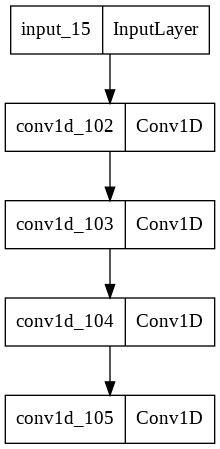

In [ ]:
plot_model(model_conv1d)

In [ ]:
history = model_conv1d.fit(GENSIMtrainX, GENSIMtrainY, epochs=5, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY)) # Обучаем модель на сверточной сети

Epoch 1/5
69/69 [==============================] - 3s 39ms/step - loss: 6.7315 - dice_coef: 0.5050 - val_loss: 5.8976 - val_dice_coef: 0.4900
Epoch 2/5
69/69 [==============================] - 2s 33ms/step - loss: 6.7187 - dice_coef: 0.5087 - val_loss: 5.8897 - val_dice_coef: 0.4926
Epoch 3/5
69/69 [==============================] - 2s 33ms/step - loss: 6.7067 - dice_coef: 0.5118 - val_loss: 5.8826 - val_dice_coef: 0.4953
Epoch 4/5
69/69 [==============================] - 2s 34ms/step - loss: 6.6958 - dice_coef: 0.5153 - val_loss: 5.8764 - val_dice_coef: 0.4982
Epoch 5/5
69/69 [==============================] - 2s 33ms/step - loss: 6.6861 - dice_coef: 0.5190 - val_loss: 5.8715 - val_dice_coef: 0.5013


## **PSPnet**
https://youtu.be/wdi8HYhgGj0?t=2141


### Стандартная архитектура

In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 256, 64)      57664       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64)     256         ['conv1d_4[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 64)      0           ['batch_normalization[0][0]

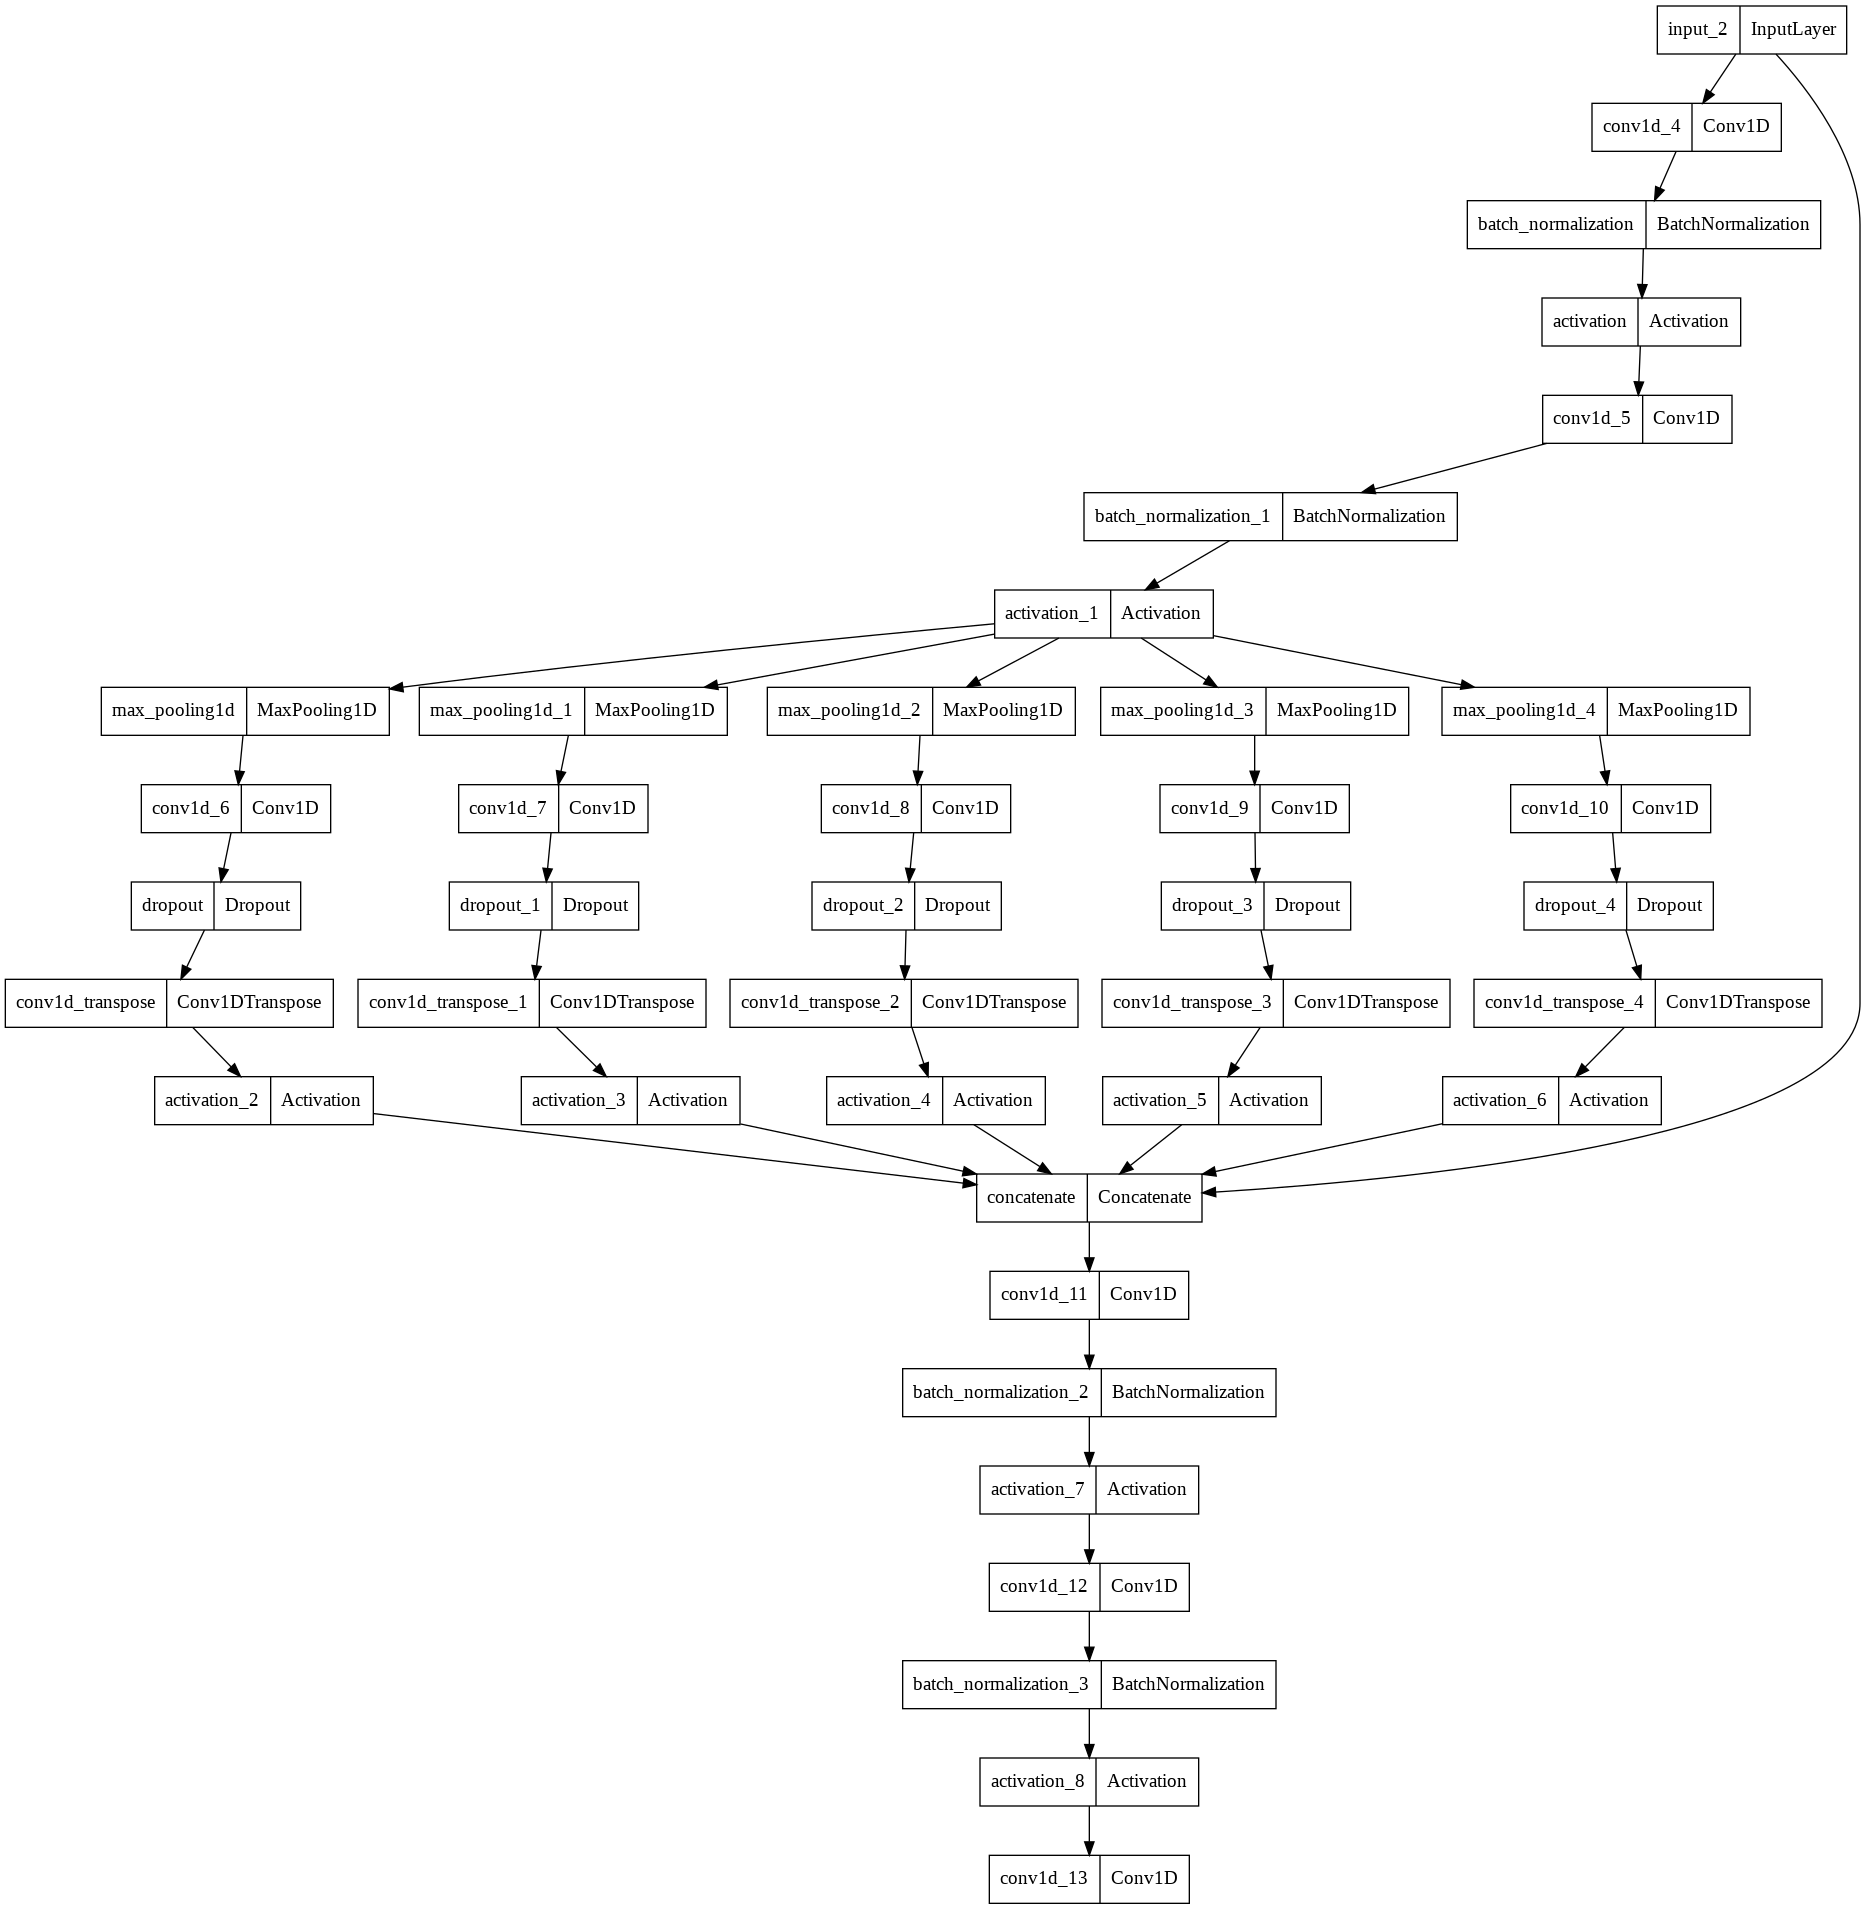

In [ ]:
plot_model(model_b_PSPnet)

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
214/214 [==============================] - 10s 35ms/step - loss: 6.7663 - dice_coef: 0.5690 - val_loss: 5.7994 - val_dice_coef: 0.5457
Epoch 2/5
214/214 [==============================] - 6s 29ms/step - loss: 6.7449 - dice_coef: 0.5743 - val_loss: 5.8596 - val_dice_coef: 0.5486
Epoch 3/5
214/214 [==============================] - 6s 30ms/step - loss: 6.7239 - dice_coef: 0.5803 - val_loss: 5.8526 - val_dice_coef: 0.5536
Epoch 4/5
214/214 [==============================] - 6s 30ms/step - loss: 6.7038 - dice_coef: 0.5868 - val_loss: 5.8360 - val_dice_coef: 0.5590
Epoch 5/5
214/214 [==============================] - 6s 30ms/step - loss: 6.6844 - dice_coef: 0.5935 - val_loss: 5.8192 - val_dice_coef: 0.5648


### 256 нейронов в свёрточном ядре

In [ ]:
model_b_PSPnet = create_PSPNet(conv_size = 256, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 256)     230656      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256)    1024        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256)     0           ['batch_normalization[0][0]']

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
214/214 [==============================] - 113s 515ms/step - loss: 7.1896 - dice_coef: 0.5312 - val_loss: 5.8986 - val_dice_coef: 0.5418
Epoch 2/5
214/214 [==============================] - 109s 510ms/step - loss: 7.1278 - dice_coef: 0.5552 - val_loss: 5.9748 - val_dice_coef: 0.5631
Epoch 3/5
214/214 [==============================] - 109s 510ms/step - loss: 7.0752 - dice_coef: 0.5807 - val_loss: 5.9530 - val_dice_coef: 0.5837
Epoch 4/5
214/214 [==============================] - 109s 511ms/step - loss: 7.0263 - dice_coef: 0.6069 - val_loss: 5.9217 - val_dice_coef: 0.6036
Epoch 5/5
214/214 [==============================] - 107s 501ms/step - loss: 6.9837 - dice_coef: 0.6322 - val_loss: 5.8935 - val_dice_coef: 0.6220


### 512 нейронов в свёрточном ядре

In [ ]:
model_b_PSPnet = create_PSPNet(conv_size = 512, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 256, 512)     461312      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 256, 512)    2048        ['conv1d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 256, 512)     0           ['batch_normalization_4[0][

In [ ]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=25, batch_size=64)

Epoch 1/25
214/214 [==============================] - 325s 2s/step - loss: 7.2061 - dice_coef: 0.5549 - val_loss: 6.1405 - val_dice_coef: 0.5370
Epoch 2/25
214/214 [==============================] - 319s 1s/step - loss: 7.0692 - dice_coef: 0.5958 - val_loss: 6.2599 - val_dice_coef: 0.5678
Epoch 3/25
214/214 [==============================] - 313s 1s/step - loss: 6.9579 - dice_coef: 0.6347 - val_loss: 6.2038 - val_dice_coef: 0.5966
Epoch 4/25
214/214 [==============================] - 308s 1s/step - loss: 6.8501 - dice_coef: 0.6673 - val_loss: 6.1102 - val_dice_coef: 0.6197
Epoch 5/25
214/214 [==============================] - 308s 1s/step - loss: 6.7410 - dice_coef: 0.6915 - val_loss: 5.9987 - val_dice_coef: 0.6387
Epoch 6/25
214/214 [==============================] - 307s 1s/step - loss: 6.6314 - dice_coef: 0.7080 - val_loss: 5.8923 - val_dice_coef: 0.6521
Epoch 7/25
214/214 [==============================] - 310s 1s/step - loss: 6.5280 - dice_coef: 0.7192 - val_loss: 5.7728 - val_dic

## **UNET**
https://youtu.be/wdi8HYhgGj0?t=2204

### Стандартная архитектура

In [ ]:
model_b_UNET = create_unet(input_shape=(xLen, embeddingSize))
model_b_UNET.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_86 (Conv1D)             (None, 256, 64)      57664       ['input_14[0][0]']               
                                                                                                  
 batch_normalization_70 (BatchN  (None, 256, 64)     256         ['conv1d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_79 (Activation)     (None, 256, 64)      0           ['batch_normalization_70[0]

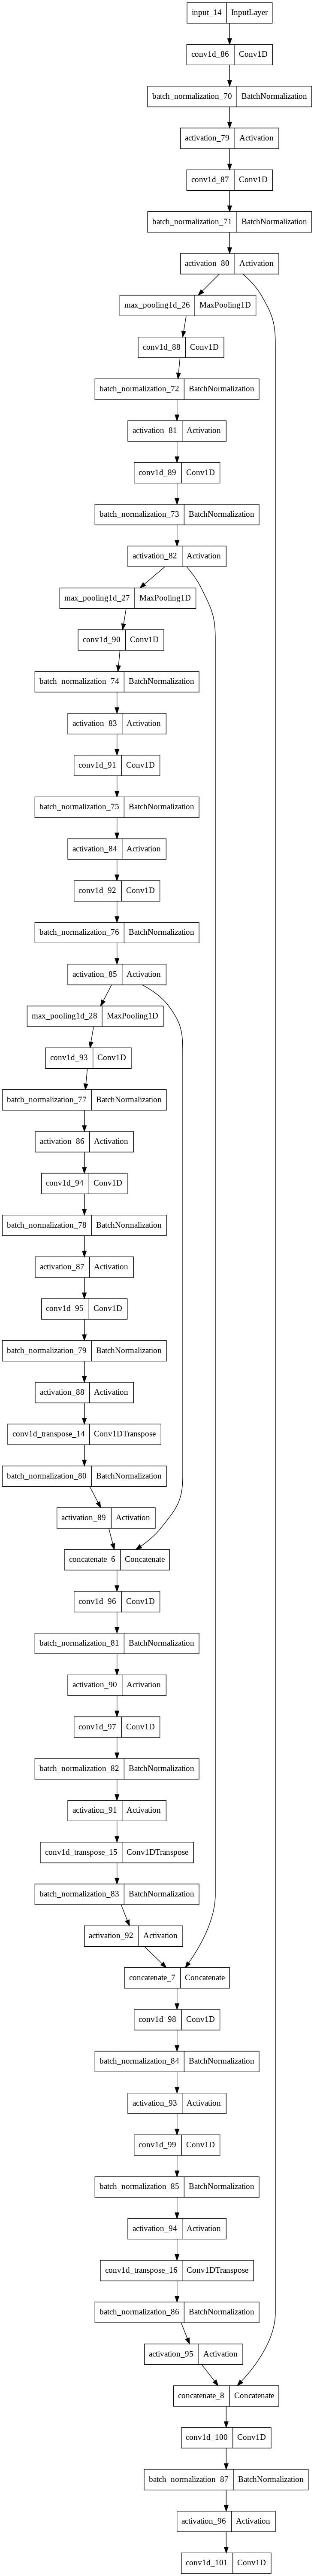

In [ ]:
plot_model(model_b_UNET)

In [ ]:
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=10, batch_size=64) # Feed the images divided among 2 classes to the model

Epoch 1/10
214/214 [==============================] - 53s 225ms/step - loss: 6.4482 - dice_coef: 0.7203 - val_loss: 7.7186 - val_dice_coef: 0.6844
Epoch 2/10
214/214 [==============================] - 47s 221ms/step - loss: 6.3101 - dice_coef: 0.7294 - val_loss: 7.9503 - val_dice_coef: 0.6823
Epoch 3/10
214/214 [==============================] - 48s 223ms/step - loss: 6.3688 - dice_coef: 0.7328 - val_loss: 7.1308 - val_dice_coef: 0.6815
Epoch 4/10
214/214 [==============================] - 48s 223ms/step - loss: 6.3993 - dice_coef: 0.7316 - val_loss: 5.9232 - val_dice_coef: 0.6799
Epoch 5/10
214/214 [==============================] - 48s 223ms/step - loss: 6.4985 - dice_coef: 0.7301 - val_loss: 5.4220 - val_dice_coef: 0.6778
Epoch 6/10
214/214 [==============================] - 47s 222ms/step - loss: 6.5417 - dice_coef: 0.7288 - val_loss: 7.4019 - val_dice_coef: 0.6771
Epoch 7/10
214/214 [==============================] - 48s 222ms/step - loss: 6.7494 - dice_coef: 0.7279 - val_loss: 5.

# **Проверяем работу сети**

https://youtu.be/wdi8HYhgGj0?t=2244

In [ ]:
def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 6) #Инициализируем массив правильных ответов в нули (сколько раз правильно определили класс)
  incorrect_list =  np.array([0] * 6)  #Инициализируем массив неправильных ответов в нули  (сколько раз неправильно определили класс)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]): # Проходим по всем примерам в батче
    for word in range(YY_array.shape[1]):  # Проходим по каждому слову
      for category in range(YY_array.shape[2]): # Проходим по каждой категории в слове
        if pred[element][word][category] == YY_array[element][word][category]: # Если предсказанное значение совпадает с истинным:
          correct_list[category] += 1 # Отмечаем, что мы правильно предсказали класс объекта
        else:  # Если предсказанное значение НЕ совпадает с истенным:
          incorrect_list[category] += 1 # Отмечаем, что мы не правильно предсказали класс объекта
      
  # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
  for i in range(6):
   print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  print("Средняя точность {}%".format(total))

In [ ]:
print('Размер xTrain:', GENSIMtestX.shape)
print('Размер yTrain:', GENSIMtestY.shape)

Размер xTrain: (384, 256, 300)
Размер yTrain: (384, 256, 6)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_conv1d, tags, xLen, 0.5) # Проверяем conv1d архитектуру

12/12 [==============================] - 0s 4ms/step
Сеть распознала категорию  'S1' с точностью в 26.88%
Сеть распознала категорию  'S2' с точностью в 62.19%
Сеть распознала категорию  'S3' с точностью в 57.86%
Сеть распознала категорию  'S4' с точностью в 52.82%
Сеть распознала категорию  'S5' с точностью в 59.09%
Сеть распознала категорию  'S6' с точностью в 75.29%
Средняя точность 55.69%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_PSPnet, tags, xLen, 0.5) # Проверяем PSPnet архитектуру

12/12 [==============================] - 3s 190ms/step
Сеть распознала категорию  'S1' с точностью в 90.91%
Сеть распознала категорию  'S2' с точностью в 62.08%
Сеть распознала категорию  'S3' с точностью в 68.29%
Сеть распознала категорию  'S4' с точностью в 85.84%
Сеть распознала категорию  'S5' с точностью в 66.66%
Сеть распознала категорию  'S6' с точностью в 8.01%
Средняя точность 63.63%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET, tags, xLen, 0.1) # Проверяем UNET архитектуру

12/12 [==============================] - 1s 35ms/step
Сеть распознала категорию  'S1' с точностью в 90.91%
Сеть распознала категорию  'S2' с точностью в 26.03%
Сеть распознала категорию  'S3' с точностью в 68.31%
Сеть распознала категорию  'S4' с точностью в 85.87%
Сеть распознала категорию  'S5' с точностью в 30.18%
Сеть распознала категорию  'S6' с точностью в 6.58%
Средняя точность 51.31%


[GENSIM Word2Vec документация](https://radimrehurek.com/gensim/models/word2vec.html)